# [모듈 4.1] MAB A/B Testing 시뮬레이션 : MAB (Multi-Armed Bandits)

이 노트북은 아래와 같은 목차로 진행이 됩니다.

1. 환경 셋업
2. 엔드포인트 추론 테스트
3. MAB A/B Testing Simulation 을 위한 심플 테스트
4. 배치 A/B 테스트 시뮬레이션 추론 실행
5. A/B 테스팅 시뮬레이션 분석
6. Winner 선출

---

# 1. 환경 셋업

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%store -r
%store

Stored variables and their in-db values:
artifact_path                                -> 's3://sagemaker-us-east-1-057716757052/pytorch-tra
bucket                                       -> 'sagemaker-us-east-1-057716757052'
challenger_model_artifact                    -> 's3://sagemaker-us-east-1-057716757052/mab-reviews
champion_model_artifact                      -> 's3://sagemaker-us-east-1-057716757052/mab-reviews
endpoint_name                                -> 'MAP-Inference-Endpoint-2022-06-17-02-02-16'
horovod_artifact_path                        -> 's3://sagemaker-us-east-1-057716757052/pytorch-tra
model_train_inference_docker_uri             -> '811284229777.dkr.ecr.us-east-1.amazonaws.com/blaz
prefix                                       -> 'NCFModel'


In [3]:
import json
import os
import boto3
import tqdm.notebook as tq
from botocore.config import Config
config = Config(retries={"max_attempts": 10, "mode": "standard"})
sm_client = boto3.client('sagemaker', config=config)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


# 2. 엔드포인트 추론 테스트
- Dynamic A/B Testing 과 상관 없이 이전 노트북에서 생성한 엔드포인트가 잘 작동하는지, 그리고 Champion, Challenger 모델이 성능이 얼마나 나오는지를 확인을 합니다.

## 2.1. 테스트 데이터 로딩

In [4]:
import pandas as pd

test_df = pd.read_csv("test.csv")
test_df.head(1)

,product_id,product_title,star_rating,helpful_votes,total_votes,review_headline,review_body,helpful_score,sentiment,product_id_total,helpful_votes_total,total_votes_total,is_helpful
0,B000EPLP3C,Zune 30 GB Digital Media Player,5,4,11,Excellent Item,This is the perfect media device for anyone wh...,0.363636,Positive,506,9240,17219,False


In [5]:
from spacy.lang.en import English

index_to_label = {0: 'NotHelpful', 1: 'Helpful'} 
nlp = English()
tokenizer = nlp.tokenizer

def labelize_df(df):
    return '__label__' + df['is_helpful'].apply(lambda is_helpful: index_to_label[is_helpful])

def tokenize_sent(sent, max_length=1000):
    return ' '.join([token.text for token in tokenizer(sent)])[:max_length]

def tokenize_df(df):
    return (df['review_headline'].apply(tokenize_sent) + ' ' + 
            df['review_body'].apply(tokenize_sent))

In [6]:

test_input = tokenize_df(test_df).to_list()
test_input[0:2]


['Excellent Item This is the perfect media device for anyone who enjoys having music , videos and pictures at your fingertips . Would definettley recommend it over the Ipod Video',
 "Outstanding Monitors I 'm a producer / director / editor at a network television production company .   We 've used these M - Audio BX5a monitors in most of our edit bays for several years now and have been very pleased with their performance .   They produce crisp , clear sound for voice , music and effects .   They 're solid , look nice and feature cool blue pilot lights on front between the woofer and tweeter.<br /><br />Highly recommended for post - production audio ."]

## 2.2. 변형 확인
"3.1.host-mab-reviews-helpfulness.ipynb" 노트북에서 1개의 엔드포인트를 생성하였고, 이는 2개의 Prdouct Variant (변형) 로 구성되어 있습니다. 2개의 변형을 확인 합니다.

In [7]:
from api.utils import chunker, parse_predictions, predict

In [8]:
variant_names = [pv['VariantName'] for pv in sm_client.describe_endpoint(EndpointName=endpoint_name)['ProductionVariants']]
if len(variant_names) < 2:
    raise Exception('Require at least 2 variants for A/B Testing')

variant_names

['Champion', 'Challenger']

## 2.3. 두 개의 변형에 각각 추론
['Champion', 'Challenger'] 의 두개의 변형에 batch_size (예: 50) 로 총 14,226 개의 레코드를 추론 합니다. 결론적으로 14,226 * 2 = 28,552 추론을 하게 됩니다.

In [9]:
%%time

batch_size = 50
test_preds = [predict(endpoint_name, variant_name, test_input, batch_size) 
              for variant_name in tq.tqdm(variant_names)]

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1.44 s, sys: 57.1 ms, total: 1.5 s
Wall time: 6.19 s


한개의 추론 예시를 보면 (True, 0.5582534670829773) 상품 리뷰가 `__label__Helpful` 이면 True, 그렇지 않으면 False 를 제공합니다. 그리고 0.558 Confidence Score 입니다.

In [10]:
import numpy as np
from IPython.display import display as dp

print("Size of input: ", len(test_input))
print("Prediction Shape: ", np.asarray(test_preds).shape)
dp(test_preds[0][0:3])
dp(test_preds[1][0:3])


Size of input:  14226
Prediction Shape:  (2, 14226, 2)


[(True, 0.5272706151008606),
 (True, 0.6354568004608154),
 (True, 0.5329211354255676)]

[(True, 0.5482327342033386),
 (True, 0.7577333450317383),
 (True, 0.501598060131073)]

test 데이터, 추론 데이터를 결합하여 확인 합니다.

In [11]:
def join_test(test_df, predictions, variant_name):
    pred_df = pd.DataFrame(predictions, columns=['is_helpful_prediction', 'is_helpful_prob'])
    pred_df['variant_name'] = variant_name
    return test_df[['is_helpful']].join(pred_df)

# Create a combined dataset for each variant and output accuracy
join_df = pd.concat([join_test(test_df, predictions, variant_names[i]) for (i, predictions) in enumerate(test_preds)])
# join_df.head(5)
join_df

,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name
0,False,True,0.527271,Champion
1,True,True,0.635457,Champion
2,True,True,0.532921,Champion
3,True,True,0.539651,Champion
4,False,False,0.800596,Champion
...,...,...,...,...
14221,True,True,0.504745,Challenger
14222,False,False,0.855869,Challenger
14223,True,True,0.606394,Challenger
14224,True,True,0.510573,Challenger


## 2.4. 두개의 변형 평가

- 아래는 예시로서 모델의 Accuracy 가 각 variant 별로 보여 주고 있습니다.

```
variant_name
Challenger    0.661043
Champion      0.651132
```


In [12]:
from sklearn.metrics import accuracy_score, f1_score

join_df.groupby('variant_name').apply(lambda g: accuracy_score(g['is_helpful_prediction'], g['is_helpful']))

variant_name
Challenger    0.657528
Champion      0.648882
dtype: float64

Confusion Matrix 를 통해서 모델이 얼마나 우수한지 확인 합니다.

Champion
[[3785 2520]
 [2475 5446]]
Challenger
[[3876 2429]
 [2443 5478]]


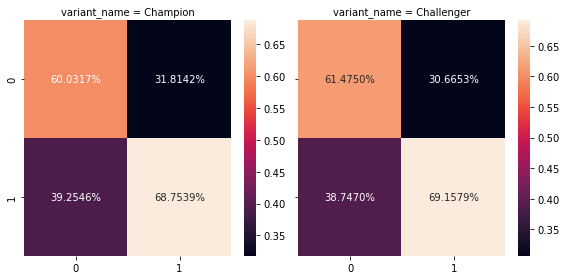

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

def draw_heatmap(data, **kwargs):
    cf_matrix = confusion_matrix(data['is_helpful'], data['is_helpful_prediction'])
    print(data['variant_name'].unique()[0])
    print(cf_matrix)
    cf_percent = cf_matrix / cf_matrix.astype(np.float).sum(axis=1)
    sns.heatmap(cf_percent, annot=True, fmt=".4%")

fg = sns.FacetGrid(join_df, col='variant_name', height=4)
fg.map_dataframe(draw_heatmap)

### ROC_AUC 계산

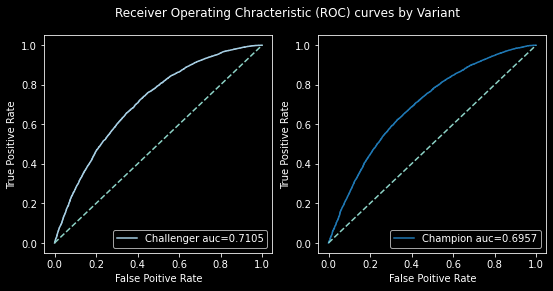

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("dark_background")



from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def plot_roc(data):
    # Create horizontally stack plots (max is to to create at least 2 charts)
    fig, axs = plt.subplots(1, max(len(variant_names), 2), figsize=(9,4))
    fig.suptitle('Receiver Operating Chracteristic (ROC) curves by Variant')
    colors = sns.color_palette("Paired")
    # Plot the ROC curves by variant name
    for i, (variant_name, pred_df) in enumerate(data.groupby('variant_name')):        
        # Get true probability for ROC
        tp = pred_df.apply(lambda r: r['is_helpful_prob'] if r['is_helpful_prediction'] else 
                           1-r['is_helpful_prob'], axis=1)
        fpr, tpr, _ = roc_curve(pred_df['is_helpful'], tp)
        auc = roc_auc_score(pred_df['is_helpful'], tp)
        axs[i].plot(fpr,tpr,color=colors[i],label=f"{variant_name} auc={auc:.4f}")   
        axs[i].plot([0, 1], [0, 1], linestyle='--')
        axs[i].set_xlabel("False Poitive Rate")
        axs[i].set_ylabel("True Positive Rate")
        axs[i].legend(loc=4)
        
plot_roc(join_df)

# 3.  MAB A/B Testing Simulation 을 위한 심플 테스트

## 3.1. MAB A/B Testing Simulation 알고리즘
- A/B 테스팅 및 시뮬레이션
    - (1) 간단한 "Variant DB" 에 초기값을 제공하여 생성 합니다.
    - (2) 추론을 위해 대상 변형 (Target Variant) 을 요청합니다.
    - (3) "Variant DB" 의 값을 기반으로 Tomson Sampling 알고리즘 을 통해서 대상 변형 (Target Variant) 를 제공합니다.
    - (4) 대상 변형을 얻은 후에 SageMaker Endpoint 에 대상 변형에 추론을 요청 합니다.
    - (5) 추론된 결과는 다시 "Variant DB" 에 업데이트를 합니다.
    - (2) ~ (5) 의 과정을 반복 합니다.



## 3.2. 변형 지표 저장을 위한 인라인 저장소 셋업




추론 횟수 (invocation), 리워드 받은 횟수 (reward) 각각 2, 1 을 각 Varaint인 Champion, Challenger 에 초기 값을 제공 합니다.
이 값은 실제적으로 "베타 분포" [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) 의 알파 (1 + reward), 베타 (1 + invocation - reward) 로 입력이 되어서, 베타 분포를 그리게 됩니다. 
- 여기서 알파의 의미는 "리워드의 횟수 (성공의 의미)" , 베타의 의미는 "리워드를 받지 못한 횟수 (실패의 의미" 로 해석을 합니다. 
- 실제적으로 아래의 함수를 통해서 베타 분포를 구합니다.
- converson 은 초기값을 제외한 순수하게 reward 를 받은 횟수 입니다. 기록용으로만 사용하고 이외는 사용하지 않습니다.

```
    def random_beta(alpha, beta):
        """
        Pure python implement of random beta
        """
        return random.betavariate(alpha, beta)


```

```
{
  "Champion": {
    "timestamp": "2022-04-21-04-22-01",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-04-21-04-22-01",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  }
}
```



In [15]:
champion_seed_invocations=2
champion_seed_reward=1
challenger_seed_invocations=2
challenger_seed_reward=1


from api.variants_linline_db import VariantsInlineDB 
variant_db = VariantsInlineDB()

variant_record = variant_db.add_variant(variant_name="Champion", 
                            invocation=champion_seed_invocations, 
                            conversion=0, 
                            reward=champion_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)

variant_record = variant_db.add_variant(variant_name="Challenger", 
                            invocation=challenger_seed_invocations, 
                            conversion=0, 
                            reward=challenger_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)




print(json.dumps(variant_db.variant_dic, indent=2))

{
  "Champion": {
    "timestamp": "2022-06-17-02-11-53",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-06-17-02-11-53",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  }
}


## 3.3. api_predict() 동작 방식
- (1) 현재 variant_db 내용을 바탕으로  Tompson Sampling 을 통한 "대상 변형" 을 연산 후에 제공
- (2) "대상 변형" 으로 batch 사이즈 만큼을 앤드폰이트로 추론 함. (예: batch_size = 1)
- (3) 1개를 추론하여 예측이 나온 것을 진실값과 비교해서 "일치" 하면 리워드 1 제공, "일지 하지 않으면" 리워드 0 제공.
    - 아래의 reward 정의 참고
        - 단 batch_size가 2 개 이상 이면 (에: 20개) 예측을 'is_helpful_prediction', 'is_helpful_prob' 로 정렬하여 Top 1 만 추출하여 reward 주는 것을 결정 함.    
- (4) reward 가 1 이면 variant_db 에 업데이트 함.
    
    
#### Reward 정의 
reward 의 정의는 진실값읜 "is_helpful"가 예측 결과와 같으면 "1" 을 부여 하는 것으로 정의 
```
['is_helpful'] == ['is_helpful_prediction']
```


In [16]:
from api.utils import api_predict

In [17]:
batch_size = 1

input_batch = list(chunker(test_input, batch_size))
test_batch = list(chunker(test_df, batch_size))
print(len(input_batch), len(test_batch))

14226 14226


In [18]:
# batch_num 값으로 배치 수 조절 
batch_num = 4

batch_df = pd.concat(api_predict(i, endpoint_name, batch_size, input_batch[i],test_batch[i],variant_db, verbose=True) 
                     for i in range(len(input_batch)) if i <= batch_num ).reset_index(drop=True)



##################################

variant_name:  Challenger
Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,False,True,0.548233,Challenger,TomsonSampling,0,1,0



##################################

variant_name:  Challenger
Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.757733,Challenger,TomsonSampling,1,1,1


--> Reward and conversion are recoded in variant_db: 

##################################

variant_name:  Champion
Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.532921,Champion,TomsonSampling,2,1,1


--> Reward and conversion are recoded in variant_db: 

##################################

variant_name:  Champion
Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,True,True,0.539651,Champion,TomsonSampling,3,1,1


--> Reward and conversion are recoded in variant_db: 

##################################

variant_name:  Challenger
Top predicton with meta data


,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,False,False,0.783341,Challenger,TomsonSampling,4,1,1


--> Reward and conversion are recoded in variant_db: 


## 3.4. 심플 테스트 결과 확인
- 위의 5번 배치에 대한 실행 요약을 봅니다.
    - 톰슨 샘플링으로 제공된 variant_name 으로 엔드포인트에 추론을 하였고, 이후에 is_helpful == is_helpful_prediction 에 따라서 reward 를 받은 것을 화인 해보세요

In [19]:
batch_df 

,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,False,True,0.548233,Challenger,TomsonSampling,0,1,0
1,True,True,0.757733,Challenger,TomsonSampling,1,1,1
2,True,True,0.532921,Champion,TomsonSampling,2,1,1
3,True,True,0.539651,Champion,TomsonSampling,3,1,1
4,False,False,0.783341,Challenger,TomsonSampling,4,1,1


In [20]:
print(json.dumps(variant_db.variant_dic, indent=2))

{
  "Champion": {
    "timestamp": "2022-06-17-02-11-56",
    "invocation": 4,
    "conversion": 2,
    "reward": 3,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-06-17-02-11-56",
    "invocation": 5,
    "conversion": 2,
    "reward": 3,
    "initial_variant_weight": 1
  }
}


# 4. 배치 A/B 테스트 시뮬레이션 추론 실행

## 4.1. 변형 지표 저장을 위한 인라인 저장소 셋업

### 변형의 수행 횟수, 리워드의 시작 값 설정
- 이번에는 seed 값을 invocation, reward 를  다시 2, 1로 초기화 합니다.

In [21]:
champion_seed_invocations=2
champion_seed_reward=1
challenger_seed_invocations=2
challenger_seed_reward=1

In [22]:

from api.variants_linline_db import VariantsInlineDB 
variant_db = VariantsInlineDB()

variant_record = variant_db.add_variant(variant_name="Champion", 
                            invocation=champion_seed_invocations, 
                            conversion=0, 
                            reward=champion_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)

variant_record = variant_db.add_variant(variant_name="Challenger", 
                            invocation=challenger_seed_invocations, 
                            conversion=0, 
                            reward=challenger_seed_reward, 
                            initial_variant_weight=1, 
                            verbose=False)




print(json.dumps(variant_db.variant_dic, indent=2))

{
  "Champion": {
    "timestamp": "2022-06-17-02-12-10",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-06-17-02-12-10",
    "invocation": 2,
    "conversion": 0,
    "reward": 1,
    "initial_variant_weight": 1
  }
}


## 4.2 MAB A/B 시뮬레이션 실행
- 이번에는 batch_num = 999 로 하여 총 1000번을 실행 합니다.

In [23]:
batch_size = 1

input_batch = list(chunker(test_input, batch_size))
test_batch = list(chunker(test_df, batch_size))
print(len(input_batch), len(test_batch))

14226 14226


In [24]:
# batch_num 값으로 배치 수 조절 
batch_num = 999

batch_df = pd.concat(api_predict(i, endpoint_name, batch_size, input_batch[i],test_batch[i],variant_db) 
                     for i in range(len(input_batch)) if i <= batch_num ).reset_index(drop=True)
batch_df 

,is_helpful,is_helpful_prediction,is_helpful_prob,variant_name,strategy,batch,invocation,reward
0,False,True,0.548233,Challenger,TomsonSampling,0,1,0
1,True,True,0.635457,Champion,TomsonSampling,1,1,1
2,True,True,0.532921,Champion,TomsonSampling,2,1,1
3,True,False,0.514194,Challenger,TomsonSampling,3,1,0
4,False,False,0.800596,Champion,TomsonSampling,4,1,1
...,...,...,...,...,...,...,...,...
995,True,True,0.513746,Challenger,TomsonSampling,995,1,1
996,True,True,0.597338,Challenger,TomsonSampling,996,1,1
997,True,True,0.771768,Challenger,TomsonSampling,997,1,1
998,False,False,0.611488,Challenger,TomsonSampling,998,1,1


In [25]:
print(json.dumps(variant_db.variant_dic, indent=2))


{
  "Champion": {
    "timestamp": "2022-06-17-02-12-25",
    "invocation": 434,
    "conversion": 272,
    "reward": 273,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-06-17-02-12-28",
    "invocation": 570,
    "conversion": 403,
    "reward": 404,
    "initial_variant_weight": 1
  }
}


# 5. A/B 테스팅 시뮬레이션 분석


## 5.1. 각 변형의 리워드 가시화 

배치 결과를 변형 비율별로 그룹화하여 총 추론 횟수, 보상 및 보상 비율을 요약합니다
- reward_rate = reward / invocation

하나의 예시로서 결과를 확인 해보겠습니다.
- 총 1000 번의 배치에서 Challenger 는 추론을 893번, Champion 은 107번을 했습니다. 즉 톰슨 샘플링으로 893, 107 번 만큼 선택 받았다는 의미 입니다.
- 리워드는 Challenger 605번 (reward rate = 0.67%) , Champion 은 63번 (reward rate = 0.58%) 을 기록 하였습니다. 그래서 누적 리워드는 Challenger 가 높고, 또한 reward rate 도 더 높습니다.

```
                invocation	reward	reward_rate
variant_name			
Challenger	  893	         605       0.677492
Champion	    107	         63	    0.588785

```


In [26]:
variant_df = batch_df.groupby('variant_name').agg({
    'invocation': 'count', 
    'reward': 'sum'
})
variant_df['reward_rate'] = variant_df.apply(lambda r: r['reward']/r['invocation'], axis=1)
variant_df.sort_values('reward_rate', ascending=False)
variant_df

,invocation,reward,reward_rate
variant_name,,,
Challenger,568,403,0.709507
Champion,432,272,0.629630


## 5.2. 배치 수 진행에 따른 누적 리워드 가시화

어느 varient 가 리워드를 더 많이 받았는지를 보여 주게 됩니다.

In [27]:
cum_df = batch_df.groupby(
    ['variant_name', 'batch'])[['invocation','reward']].sum().groupby(level=0).cumsum() #.reset_index()
cum_df['reward_rate'] = cum_df.apply(lambda r: 1.0 * r['reward'] / r['invocation'], axis=1)

Text(0.5, 1.0, 'Reward by Variant')

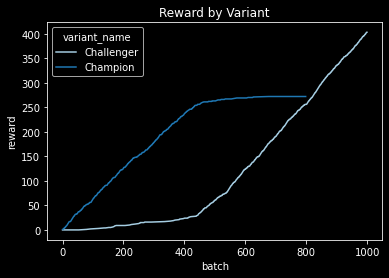

In [28]:
import seaborn as sns

sns.lineplot(data=cum_df, x="batch", y="reward", hue="variant_name", palette="Paired").set_title("Reward by Variant")

## 5.3. 배치 실행에 따른 보상 비율 (Reward Rate) 가시화
- 누적으로 reward rate 를 보여 줍니다. 
- 최종적으로 reward rate 가 높은 variant 가 더 좋은 성능을 보인다고 해석이 됩니다.

Text(0.5, 1.0, 'Reward Rate by Variant')

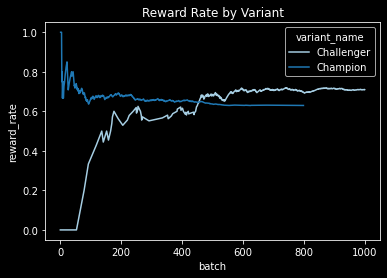

In [29]:
sns.lineplot(data=cum_df, x="batch", y="reward_rate", hue="variant_name", palette="Paired").set_title("Reward Rate by Variant")

## 5.4. 베타 분포 (Beta Distribution) 가시화

- 아래의 그림은 Champion, Challenger 의 "도움 있음 횟수" (1 + rewards), "도움 없음 횟수" (1 + invocations - reward) 를 제공하여 Beta 분포를 생성한 그림 입니다. 
- Beta 분포의 형태가 "세로로 얇아지고, 오른쪽으로 갈수록" 더욱더 더 많이 선택이 됩니다.




In [30]:
# Cut the results into 9 bucket, and plot on a 3x3 chart
bucket = 9
beta_df = cum_df.reset_index()
beta_df['bucket'] = pd.cut(beta_df['batch'], [0,2,5,10,20,50,100,200,500,1000], right=True)
beta_df = beta_df.groupby(['variant_name', 'bucket'])[['invocation', 'reward']].max()

Plot the beta distribution for each bucket

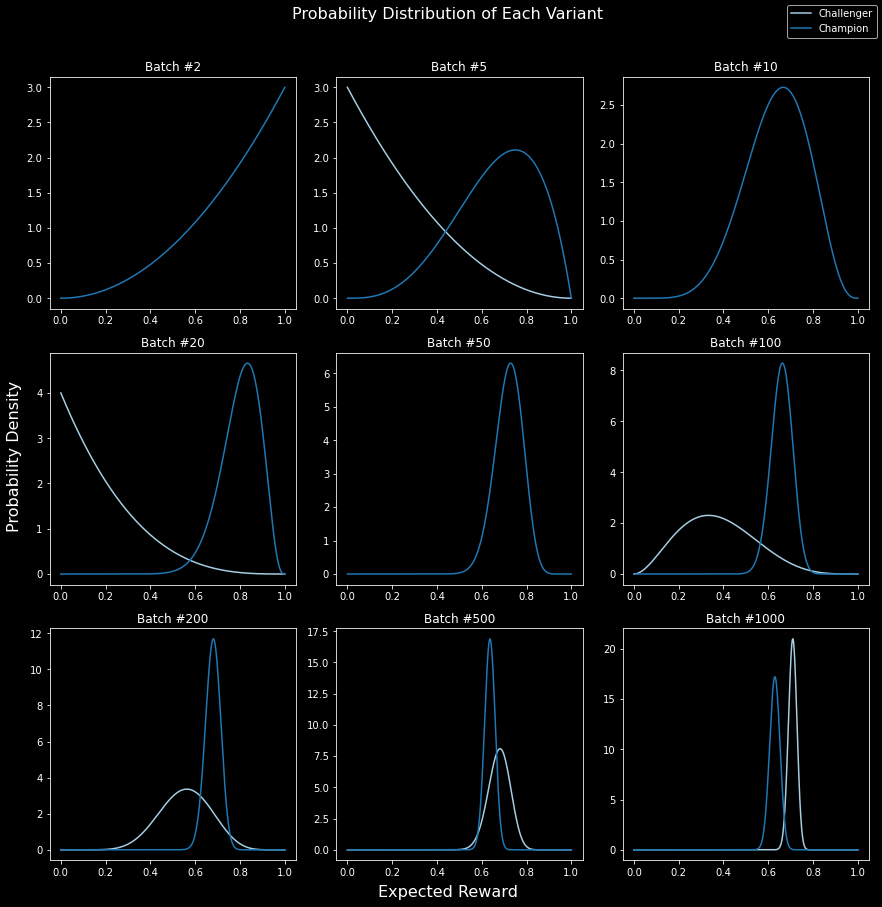

In [31]:
import numpy as np        
from scipy import stats
import matplotlib.pyplot as plt
colors = sns.color_palette("Paired")
plt.style.use("dark_background")

def plot_beta(beta_df):
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace = .5, wspace=.1)
    fig.suptitle('Probability Distribution of Each Variant', fontsize=16, y=1.02)
    fig.subplots_adjust(top=0.88)
    axs = axs.ravel()
    
    x = np.arange (0, 1.001, 0.001)
    for i, (b, bg) in enumerate(beta_df.groupby('bucket')):
        for j, (variant_name, vg) in enumerate(bg.groupby('variant_name')):
            v = vg.max()
            alpha, beta = 1+v['reward'], 1+v['invocation']-v['reward']
            axs[i].plot(x, stats.beta.pdf(x, alpha, beta), label=variant_name, color=colors[j])
        axs[i].set_title(f'Batch #{int(b.right)}')
        axs[i].grid(False)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    fig.text(0.5, -.01, 'Expected Reward', ha='center', fontsize=16)
    fig.text(-.01, 0.5, 'Probability Density', va='center', fontsize=16, rotation='vertical')
    fig.tight_layout()
    plt.show()        
plot_beta(beta_df)

# 6. Winner 선출



In [32]:
variant_a, variant_b = variant_names[:2]
rate_a, num_a = variant_df.loc[variant_a]['reward_rate'], variant_df.loc[variant_a]['invocation']
rate_b, num_b = variant_df.loc[variant_b]['reward_rate'], variant_df.loc[variant_b]['invocation']
rate_diff = (rate_b - rate_a) / rate_a
rate_dir = f'{rate_diff:.2%} higher' if rate_diff > 0 else f'{-rate_diff:.2%} lower'
print(f"{variant_a}, \treward_rate: {round(rate_a,3)}, # of invocations : {int(num_a)}")
print(f"{variant_b}, \treward_rate: {round(rate_b,3)}, # of invocations : {int(num_b)}")
print("")
print(f'{variant_b} reward rate ({rate_b:.2%}) is {rate_dir} than {variant_a} rate ({rate_a:.2%})')



Champion, 	reward_rate: 0.63, # of invocations : 432
Challenger, 	reward_rate: 0.71, # of invocations : 568

Challenger reward rate (70.95%) is 12.69% higher than Champion rate (62.96%)


## 신뢰 점수 평가
정규 분포를 가정하고 가장 실적이 좋은 변형에 대한 신뢰 점수를 평가해 보겠습니다.

In [33]:
from scipy.stats import norm

def plot_distribution(variant_a, rate_a, num_a, variant_b, rate_b, num_b):
    # Calculate the standard error for a and b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    p_value = norm().sf(z_score)
    conf = norm.cdf(z_score)
    # Plot distribution
    click_rate = np.linspace(0, 1.0, 200)
    prob_a = norm(rate_a, std_a).pdf(click_rate)
    prob_b = norm(rate_b, std_b).pdf(click_rate)    
    plt.plot(click_rate, prob_a, label=variant_a, color=colors[1])
    plt.plot(click_rate, prob_b, label=variant_b, color=colors[0])
    plt.legend(frameon=True)
    plt.xlabel("Conversion rate"); plt.ylabel("Probability");
    plt.title(f"zscore is {z_score:0.3f}, with p-value {p_value:0.3f}")
    return z_score, p_value, conf

The result is statisticially significant
Confidene score: 0.996


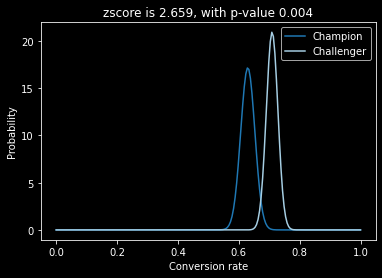

In [34]:

# Plot distribution and get confidence interval
z_score, p_value, conf = plot_distribution(variant_a, rate_a, num_a, variant_b, rate_b, num_b)

if rate_diff > 0 and conf > 0.95:
    print(f'The result is statisticially significant')
print(f"Confidene score: {round(conf,3)}")

## 최종 Variant Metrics

In [35]:
print(json.dumps(variant_db.variant_dic, indent=2))

{
  "Champion": {
    "timestamp": "2022-06-17-02-12-25",
    "invocation": 434,
    "conversion": 272,
    "reward": 273,
    "initial_variant_weight": 1
  },
  "Challenger": {
    "timestamp": "2022-06-17-02-12-28",
    "invocation": 570,
    "conversion": 403,
    "reward": 404,
    "initial_variant_weight": 1
  }
}


# 7. 엔드포인트 삭제

- <font color="red" size="5">작업이 완료시에 주석을 해제하시고 **반드시** 실행하여 엔드포인트를 삭제 해주세요. 안그러면 과다한 요금이 청구 됩니다.</font>

In [36]:
# from api.utils import delete_endpoint
# import boto3
# boto3_client = boto3.client('sagemaker')
# delete_endpoint(boto3_client, endpoint_name, is_del_model=True )

<font color="red" size=5 > 또한 삭제 후에 더블 체크를 위하여 세이지 메이커의 콘솔에서 "앤드포인트" 가신 후에 엔드포인트가 삭제가 되었는지를 확인하세요.</font>

![endpoint_console](img/endpoint_console.png)